## Финальный проект: вариант 1

поток 15.07.22 KarpovCourses. Data Analytics26

In [47]:
import pandas as pd
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import norm, mannwhitneyu

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from datetime import datetime

### Задание 1.

#### Необходимо написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [43]:
# Загружаем данные
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

### ПРедобработка данных
Выполним базовую проверку датасетов: период данных,типы данных, пропущенные значения

In [4]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [6]:
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [7]:
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [8]:
# Приведем ts к формату дат
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.round('d') 
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.round('d')

In [9]:
reg_data

,reg_ts,uid
0,1998-11-18,1
1,1999-07-23,2
2,2000-01-14,3
3,2000-05-29,4
4,2000-09-16,5
...,...,...
999995,2020-09-24,1110618
999996,2020-09-24,1110619
999997,2020-09-24,1110620
999998,2020-09-24,1110621


In [10]:
auth_data

,auth_ts,uid
0,1998-11-18,1
1,1999-07-23,2
2,1999-07-26,2
3,1999-07-31,2
4,1999-08-06,2
...,...,...
9601008,2020-09-24,1110618
9601009,2020-09-24,1110619
9601010,2020-09-24,1110620
9601011,2020-09-24,1110621


In [11]:
# Видим период регистрациии\авторизации  с 1998г. по 2020г.

In [12]:
reg_data.isnull().sum()

reg_ts    0
uid       0
dtype: int64

In [13]:
auth_data.isnull().sum()

auth_ts    0
uid        0
dtype: int64

#### Напишем функцию, которая будет считать retention игроков (по дням от даты регистрации игрока)

Входными параметрами будут два наших подгруженных датасета с регистрацией и авторизацией.
Так как период за который мы расматриваем данные включает в себя два десятилетия, считаю полезно иметь
параметры ограничивающие период анализа данных. 

start_date - начало периода расчета retation. 
end_date - конец периода расчета retation. 
с помощью которых можно выбрать сэмпл для анализа, в рамках заданного диапазона.

In [14]:
def retention_gamers(reg_data,auth_data,start_date, end_date):
    '''
    reg_data -  данные о времени регистрации
    auth_data - данные  о времени захода пользователей в игру
    start- начало периода расчета retation
    end - конец периода расчета retation
    '''
    # задаем начальную и конечную даты сэмпла 
    start = datetime.fromisoformat(start_date)
    end = datetime.fromisoformat(end_date)
    
     # Отбираем значения для заданного диапазона дат
    reg_data = reg_data.query('reg_ts >= @start and reg_ts <= @end')
    auth_data = auth_data.query('auth_ts >= @start and auth_ts <= @end')    
  
    # Объединим данные в  таблицу auth_data, у авторизованных польтзователей добавиться дата регистрации
    auth_data = auth_data.merge(reg_data, on='uid')  
 
    # Создаём колонку с количеством дней, с момента регистрации пользователя
    auth_data['days_from_regist'] = (auth_data['auth_ts'] - auth_data['reg_ts']).dt.days  
    
    # Посчитаем кол-во зарегестрированных пользователей по дням
    cohort_data = auth_data.groupby(['reg_ts', 'days_from_regist'])['uid'] \
                           .nunique().reset_index()  
    # Собираем таблицу с количеством игроков в каждый день в зависимости от их даты регистрации
    cohort_counts = cohort_data.pivot(index='reg_ts', 
                                      columns='days_from_regist', 
                                      values='uid')  
    #Определяем размеры каждой когорты
    registrations = cohort_counts[0]  
    
    #Разделим каждодневное количество пользователей для каждой когорты на размер когорты
    retention = cohort_counts.divide(registrations, axis=0).round(2).mul(100)
    retention = pd.DataFrame(retention)

    return retention

In [15]:
# зададим  даты, для анализа  выборочного сэмпла, в заданном  диапазоне.

start_date = '2019-06-01'
end_date   = '2019-07-01'

In [16]:
retention_cogorts = retention_gamers(reg_data, auth_data, start_date, end_date)
retention_cogorts

days_from_regist,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_ts,,,,,,,,,,,,,,,,,,,,,
2019-06-01,100.0,1.0,5.0,4.0,6.0,7.0,7.0,7.0,5.0,6.0,...,4.0,3.0,4.0,3.0,4.0,3.0,3.0,2.0,5.0,2.0
2019-06-02,100.0,2.0,4.0,5.0,5.0,5.0,6.0,4.0,5.0,4.0,...,3.0,3.0,4.0,2.0,3.0,4.0,4.0,2.0,2.0,NaN
2019-06-03,100.0,2.0,4.0,3.0,5.0,5.0,7.0,6.0,4.0,6.0,...,4.0,3.0,4.0,3.0,5.0,4.0,3.0,4.0,NaN,NaN
2019-06-04,100.0,2.0,4.0,3.0,6.0,6.0,5.0,4.0,4.0,5.0,...,4.0,3.0,3.0,3.0,3.0,4.0,3.0,NaN,NaN,NaN
2019-06-05,100.0,1.0,3.0,5.0,5.0,5.0,7.0,6.0,5.0,5.0,...,4.0,3.0,4.0,3.0,3.0,4.0,NaN,NaN,NaN,NaN
2019-06-06,100.0,2.0,3.0,6.0,6.0,8.0,7.0,5.0,6.0,6.0,...,3.0,4.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN
2019-06-07,100.0,2.0,5.0,4.0,5.0,6.0,7.0,6.0,5.0,6.0,...,4.0,5.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-08,100.0,2.0,3.0,5.0,6.0,6.0,7.0,6.0,4.0,5.0,...,3.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-09,100.0,2.0,4.0,4.0,5.0,7.0,7.0,6.0,4.0,5.0,...,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


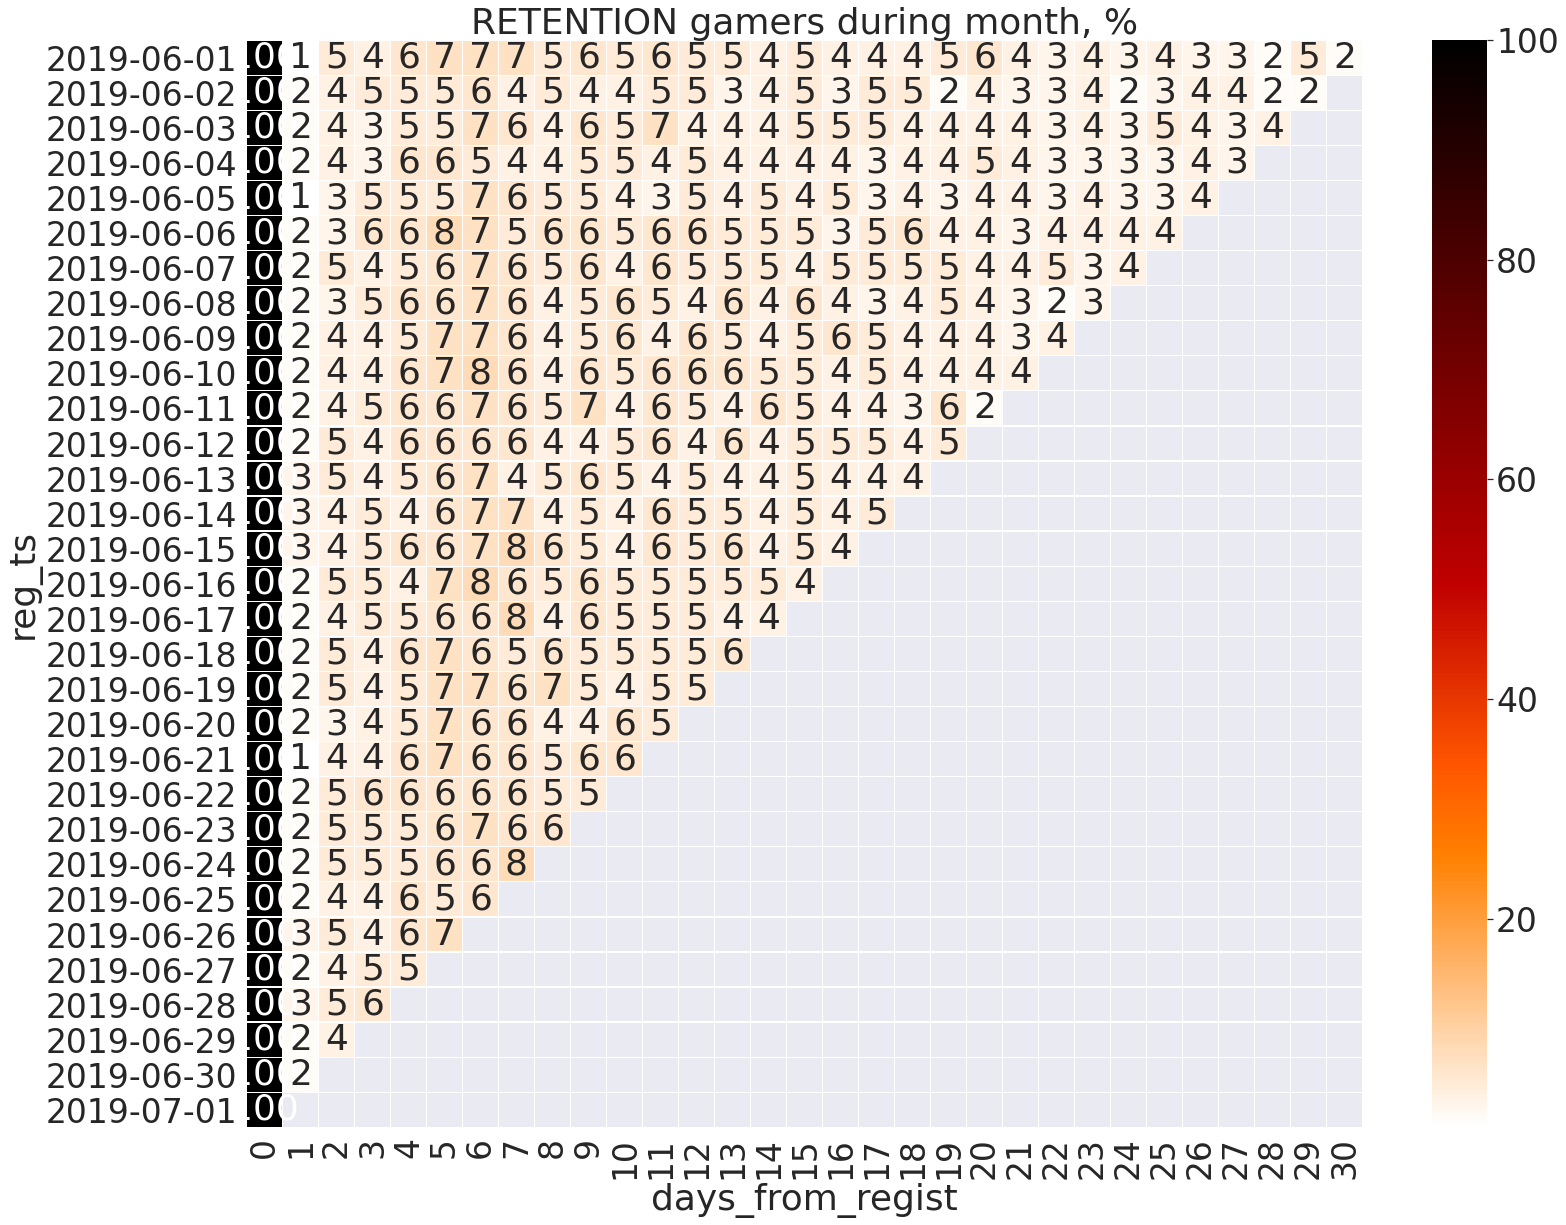

In [64]:
# Heatmap Визуализация, для наглядности:  

plt.figure(figsize=(25, 20))
plt.title('RETENTION gamers during month, %')
ax = sns.heatmap(data=retention_cogorts, annot=True, linewidth=.3, fmt='.3g',cmap='gist_heat_r')
ax.set_yticklabels(retention_cogorts.reset_index().reg_ts.astype(str).str[:12]) 
plt.show()

### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 

Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. 
При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? 
Какие метрики стоит проанализировать для принятия правильного решения и как?

In [48]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline 

In [49]:
df = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SOkIsD5A8xlI7Q', sep=';') 

In [50]:
df.head(2)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a


### ПРедобработка данных
Выполним базовую проверку датасетов: типы данных, пропущенные значения, дубликаты user_id. 

In [51]:
df.shape

(404770, 3)

In [52]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [53]:
#Проверяю на наличия пропущенных значений
df.isnull().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [54]:
#дубликаты user_id
df.user_id.duplicated().sum()

0

### Проверка исходных данных условиям задания 
проверим условия задачи: ARPU в тестовой группе выше на 5%, чем в контрольной.
a- контрольная группа, 
b- тестовая группа

In [55]:
# Кол-во игроков в контрольной группе
df.query('testgroup == "a"').shape[0]

202103

In [56]:
# Кол-во платящих игроков в контрольной группе
df.query('testgroup == "a" and revenue >0').shape[0]  

1928

In [57]:
# Кол-во игроков в тестовой группе
df.query('testgroup == "b"').shape[0]

202667

In [58]:
# Кол-во платящих игроков в тестовой группе
df.query('testgroup == "b" and revenue >0').shape[0]  

1805

In [59]:
# Считает ARPU для групп
df.groupby('testgroup', as_index=False) \
    .agg({'revenue': 'mean'})

,testgroup,revenue
0,a,25.413720
1,b,26.751287


Разница составляет 5%. 
Данные совпадают, приступаем к заданию.

### ВИЗУАЛИЗАЦИЯ распределения плательщиков в группах 

In [60]:
#Сформируем  платящие когорты в каждой группе , для визуализации 
a_revenue = df.query('testgroup == "a" and revenue > 0')
b_revenue = df.query('testgroup == "b" and revenue > 0')

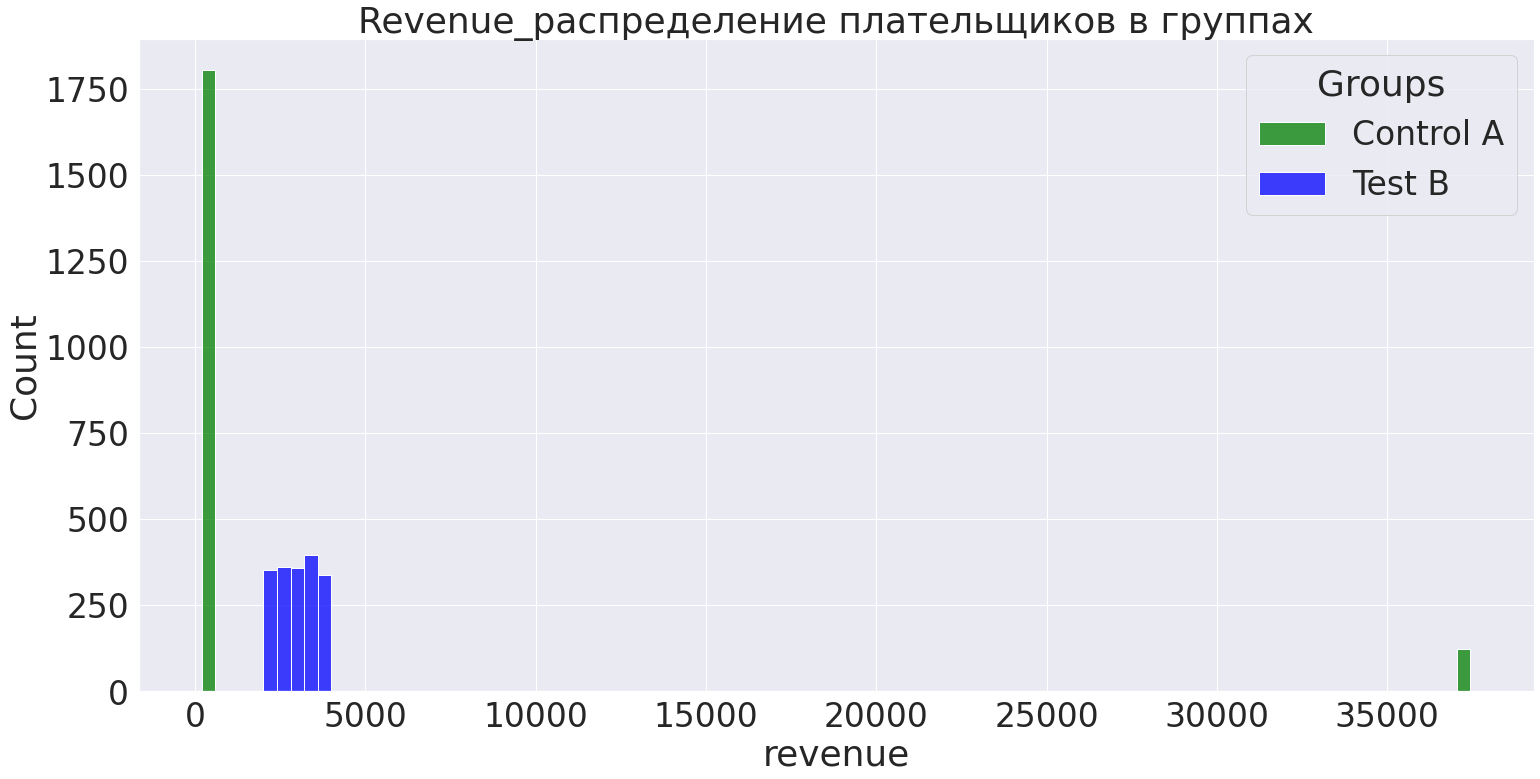

In [61]:
# Визуализируем распределение revenue по платящим пользователям
sns.set(rc={'figure.figsize': (25, 12)})
sns.set(font_scale=3)
sns.histplot(data=a_revenue, x='revenue', color='green', bins=100)
sns.histplot(data=b_revenue, x='revenue', color='blue', bins=5)
plt.title('Revenue_распределение плательщиков в группах')  
plt.legend(title='Groups', loc='upper right', labels=['Control A', 'Test B'])

Распределения плательщиков контрольной (А)  и тестовой (B) групп очень сильно отличаются. 

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


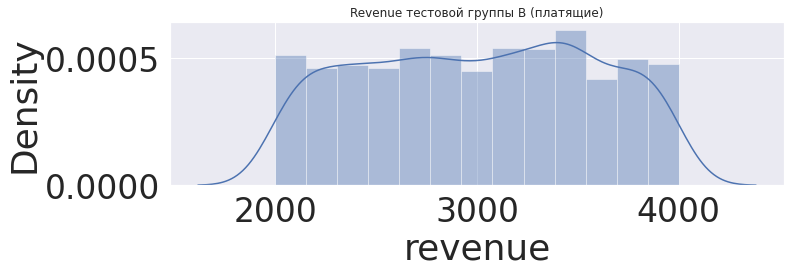

In [62]:
#посмотрим подробно плательщиков B группы 
plt.figure(figsize=(11, 3))
sns.distplot(df.query('testgroup == "b" and revenue > 0').revenue)
plt.title('Revenue тестовой группы B (платящие)', fontsize=12);

Распределение revenue платящих пользователей группы B-  выглядит более равномерным

In [63]:
# Посчитаем количество пользователей группы А, кто платит существенно больше, чем основная группа пользователей
df.query('testgroup == "a" and revenue > 5000').user_id.count()  

123

In [64]:
# посчитаем процент выручки от данных пользователей в  группе А
round((df.query('testgroup == "a" and revenue > 5000') 
       .revenue.sum() / df.query('testgroup == "a" and revenue > 0') 
       .revenue.sum()) * 100, 1) 

89.4

#### Промежуточный вывод 
В контрольной группе А -основная часть пользователей платит небольшую сумму, и есть также часть пользователей (123 пользователя), кто платит очень много (более 35тр.) и при этом процент выручки с этих пользователей почти 90%. 
При этом в тестовой группе В- все пользователи платят значительные суммы до 5000.

####   Дизайн AB test 

сформулируем гипотезы для проверки:

(H0)Нулевая гипотеза : Различия между  тестовой и контрольной группами отсутсвуют, при различных аукционных механиках.

 (H1)Альтернативная гипотеза: Различия между группами есть, при различных механиках 


    Являются ли различия между группами статистически значемыми ?
    Насколько сильно влияют 11% процентов пользователей в группе "a" на различия между группами ? 
    проанализируем отдельно платящие группы  в обоих группах

#### Шаг 1  Статистический критерий сравнения 2 выборок T-test
Что бы сравнить средние двух выборок, лучше всего подходит t-test, но необходимо проверить выполнение основных условий  проведения теста: 
1.Дисперсия гомогенна (оценим с помощью критерия Левена)
2.нормальность (оценим тестом ШАпиро-Уилка) 

In [65]:
a_group_revenue = df.query('testgroup == "a"').revenue
b_group_revenue = df.query('testgroup == "b"').revenue

In [66]:
# Оценка Гомогенности Дисперсии с помощью теста ЛЕвена

alpha = 0.05
test_leven, p = levene(a_group_revenue, b_group_revenue)
print('Statistics=%.3f, p-value=%.3f' % (test_leven, p))

if p < alpha:
    print('Отклонить гипотезу о равенстве дисперсий')
else:
    print('Принять гипотезу о равенстве дисперсий')

Statistics=0.390, p-value=0.532
Принять гипотезу о равенстве дисперсий


Тест Левана позволяет нам, говорит о том, что дисперсии равны.

In [67]:
# Оценка нормальности по р-уровню,  где значимость хотим больше 0.05

print('A:', shapiro(a_group_revenue))
print('B;', shapiro(b_group_revenue))

A: ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)
B; ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)


/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Тест Шапиро-Уилка говорит нам, что Распределения не нормальны и t-test нем не подходит.
Воспользуемся тестом U-критерий Манна-Уитни,который поможет провести исследование  и подсказать нам какую гипотезу мы примем.

In [68]:
from scipy.stats import norm, mannwhitneyu

In [69]:
#проведем тест  по критерию Манна-Уитни на полных группах
# Оценка  по р-уровню,  где значимость смотрим по уровню ниже  0.05
scipy.stats.mannwhitneyu(df[df.testgroup == "a"].revenue, df[df.testgroup == "b"].revenue)

MannwhitneyuResult(statistic=20491259376.0, pvalue=0.06269701316074398)

 pvalue=0.06 >0.05  значит H0 принимаем

In [70]:
#Проведем повторно  тест Манна-Уитни  уже отдельно для платящих пользователей
scipy.stats.mannwhitneyu(df[df.testgroup == "a"].query('revenue > 0').revenue,
                         df[df.testgroup == "b"].query('revenue > 0').revenue)

MannwhitneyuResult(statistic=222015.0, pvalue=0.0)


Оценка  по р-уровню,  где значимость смотрим по уровню ниже  0.05.

pvalue=0.0 < 0.05     здесь выбборки отличаются, значит H1 принимаем (Различия между группами платящих есть, при различных механиках).
окончательные выводы сделать не можем, все неоднозначно и применим на след. шаге -бутстрап

#### Шаг 2 Бутстрап распределения ARPU в обоих группах 

В контексте нашей задачи,  запустим бутстрап на 1000 итераций , получим распределение arpu  в группах  и   посмотрим  попадание нуля в  доверительный интервал, при попадании  подтверждаем  гипотезу HO, рпи непопадании - Н1.

#### 2.1. Бутстрап для всех пользователей обоих групп 

In [71]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

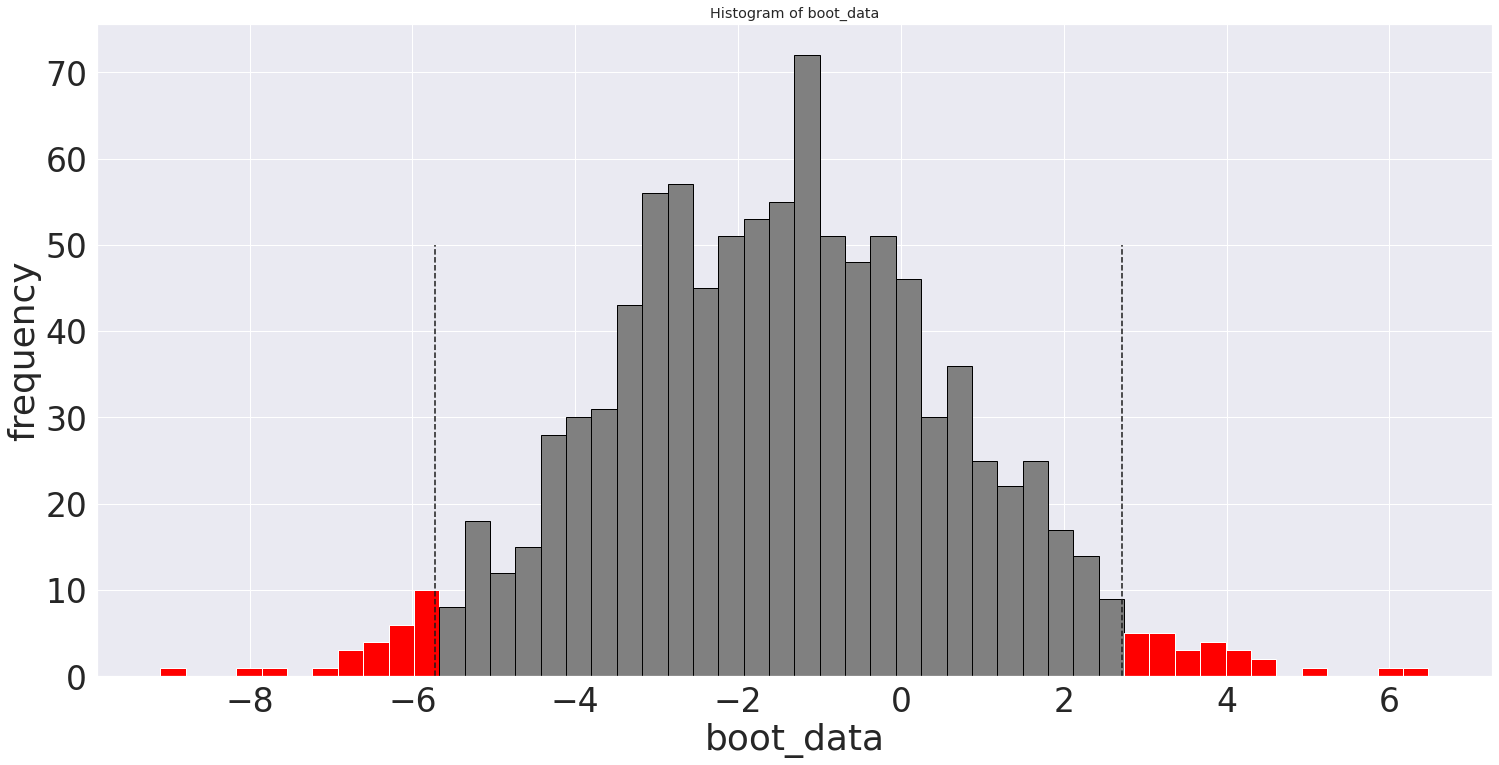

In [72]:
# бутстрап (с np.mean)
booted_data_mean = get_bootstrap(df[df.testgroup == "a"].revenue, 
                                 df[df.testgroup == "b"].revenue, 
                                 boot_it = 1000,
                                 statistic = np.mean)

#### промежуточный результат
Видим, что 0 попадает в доверительный интервал, то есть статистической разницы по ARPU мы не выявили.

Такой же вывод можно сделать на основании p-value.

In [73]:
# бутстрап (с np.mean), p-value
booted_data_mean['p_value']

0.49336134272674725

p-value при использовании бутстрапа с np.mean существенно выше 0.05, что говорит об отсутствии статистически значимых различий между группами.

#### 2.2. Бутстрап для платящих пользователей обоих групп 

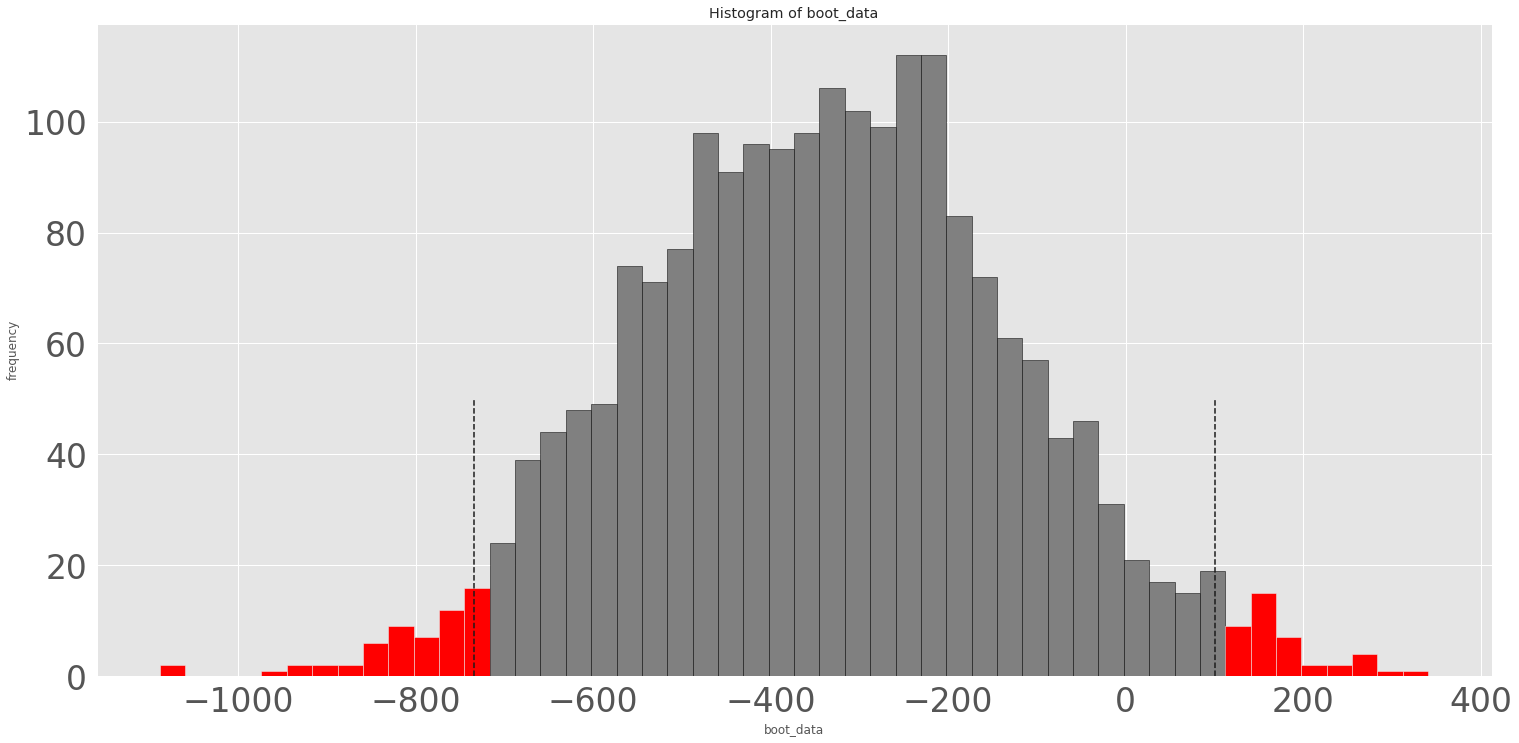

In [74]:
#Проведем такой же анализ для платящих пользователей
booted_data_mean_pu = get_bootstrap(df[df.testgroup == "a"].query('revenue > 0').revenue, 
                                    df[df.testgroup == "b"].query('revenue > 0').revenue, 
                                    boot_it = 2000 
                                    )

In [75]:
booted_data_mean_pu['p_value']

0.11084067662895752

p-value при использовании бутстрапа с np.mean также выше 0.05, что говорит об отсутствии статистически значимых различий между группами.

####  2.1. промежуточный результат
На основании проведенного анализа получается, что с точки зрения выручки мы не видим разницы между данными наборами. 

#### 2.3. Бутстрап для 09 % платящих пользователей обоих групп 

БУстрап анализ  для   выручки от 90% платящих пользователей, 
 так как выше мы уже определили, что именно характер распределения платящих пользователей существенно отличается между этими 2 группами.

In [79]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа (квантили)
def get_bootstrap_quantile(
        data_column_1,  # числовые значения первой выборки
        data_column_2,  # числовые значения второй выборки
        boot_it=1000,  # количество бутстрэп-подвыборок
        qu=0.9,  # какой квантиль смотрим
        bootstrap_conf_level=0.95):  # уровень значимости
   
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len,   
    replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(np.quantile(a=(samples_1 - samples_2), q=qu))  # - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= ci.iloc[0][0] or bar.get_x() >= ci.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
                   
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

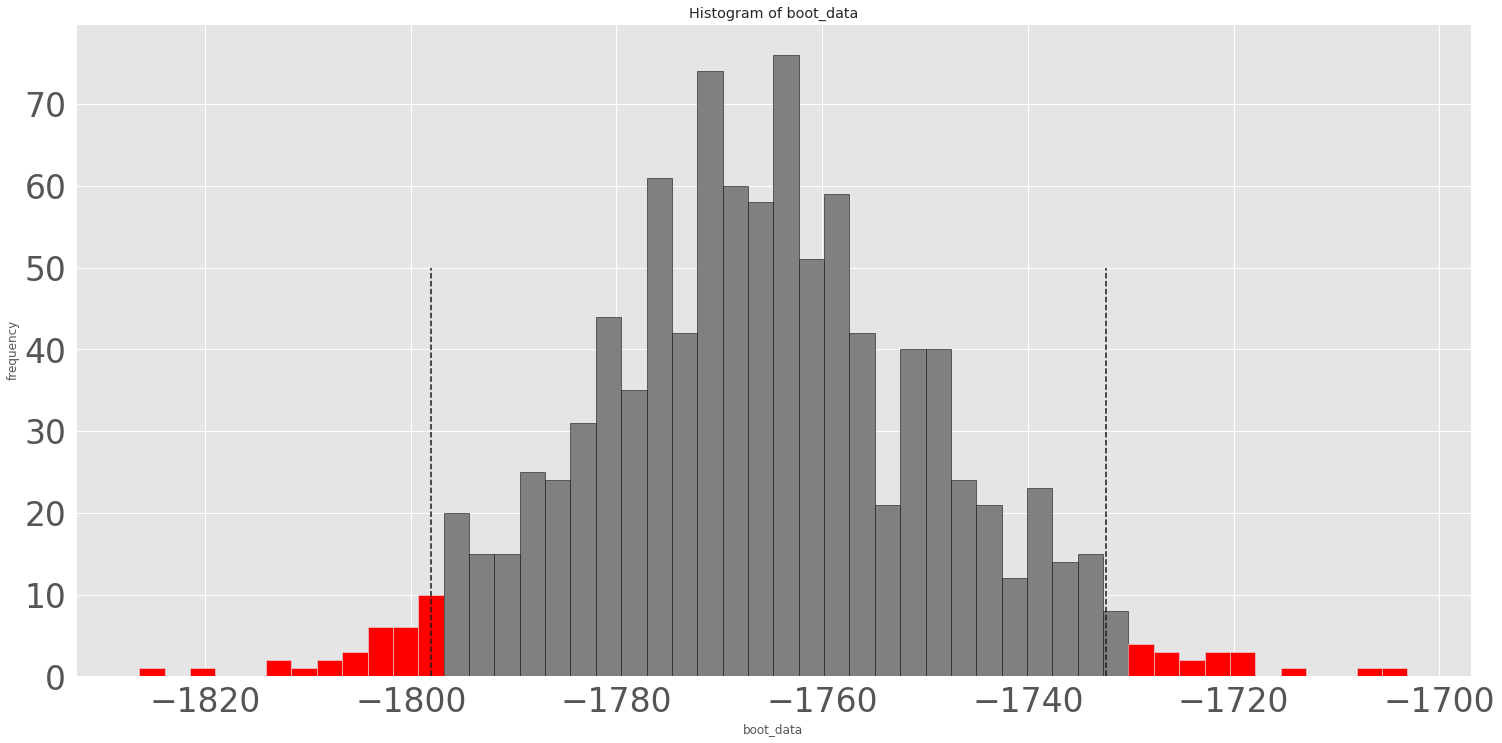

In [80]:
quantil_data_90_ppu = get_bootstrap_quantile(df[df.testgroup == "a"].query('revenue > 0').revenue, 
                                             df[df.testgroup == "b"].query('revenue > 0').revenue, 
                                             boot_it=1000, qu=0.90 
                                             )   # какой квантиль смотрим

В контрольной группе 90% пользователей платит заметно меньше, чем 90% пользователей в тестовой группе, то есть здесь отличия являются стат значимыми.


## Общие выводы:
На основании проведенного анализа получается:

1. с точки зрения выручки мы не видим разницы между данными группами, то есть набор акционных предложений не оказал стат значимого влияния на ARPPU (ARPU в тестовой группе выше на 5%, чем в контрольной).

2.Но...
при этом существенно различается  структура платящих пользователей в данных группах. 
В контрольной группе основная часть пользователей платит небольшую сумму, и есть также часть пользователей (123 пользователя), кто платит очень много и при этом процент выручки от этих пользователей почти 90%. При этом в тестовой группе все пользователи платят значительные суммы от 2000 до 4000.

3.Какой вариант можно считать лучшим? 

С точки зрения прибыли, разницы между группами нет. Но учитывая различную структуру платящих, это скорее вопрос выбора продакта: 

Вариант1 
выделить и работать с небольшой группой платящих пользователей и удерживать их, либо

Вариант 2 
продолжать работу со всеми  пользователями, которые платят в среднем от 2000 до 4000. 

Соответсвенно выбор акционных предложений будет  сущесвтенно отличаться  для каждой ЦА. 

Мое предложение продакту:  

 -обновления не выкатывать на всех, исследовать причины появление пользователей крупных плательщиков ,  в контрольной группе;
 -Основной вараинт -это Вариант 2, так как в данном случае риск потери прибыли значительно меньше при потере нескольких пользователей.
 - указать продакту  о том, в контрольной группе есть 10% пользователей платящих сильно больше чем остальные пользователи .
 Как следствие они сильно влияют на распределение revenue в контрольной группе;
 
 -ВАраинт1 -выделить в отд.направление работы.



### Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. 

#### С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. 

#### Изменится ли набор метрик оценки результата? Если да, то как?


### ОТВЕТ

### Вариант 1

Думаю темат. события необходимо рассматривать как средство  массового привлечения и увеличения прибыли, поэтому рассматриваем метрики:
    
    -DAU\WAU -кол-во игроков ежедневно\еженедельно;
    -когортный анализ новых игроков в течении 1-2-3- месяцев на рост ARPU  и оттока;
    -среднее время сессии игрока- (отношение ко времени вне темат. событий);
    -ARPU - сравнить периоды ,возможно в  темат события  сильно меняется данная метрика (увеличение \снижение);
    -конверсия в различные периоды;
    -Churn rate (отток);
    Необходимо данные метрики отслеживать  и  комбинировать  чтобы понять  успешность применения  темат. событий.
 
 ### Вариант 2 (усложненная механика)
 
 Думаю усложненная механика ,в сравнении с вариантом 1 более негативно повлияла бы на вышеуказанные метрики.
 
 
 К метрикам вараинта 1  я бы добавил:
  
 -когортный анализ вышедших игроков после 1\2\3 отката;
 -интервал между сессиями игроков вышедших после 1\2\3 отката - для оценки ввозврата в игру и пониманием точки невозврата;
 -время прохождения уровней и кол-во акт. игроков - для оценки новой механики на предмет уменьшения \увеличения кол-ва пользователей. 